This is a worked example about how we could use the framework for real work
The cells are going to repeat in content, but you should think about actually 
doing it all in one cell, progressively hacking the code towards the right result

In [1]:
from databaker.framework import *
inputfile = "ott.xls"
outputfile = "ott.csv"
previewfile = "preview.html"

tabs = loadxlstabs(inputfile)


Loading ott.xls which has size 193536 bytes
Table names: ['Index', 'Table 1', 'Table 2', 'Table 3', 'Table 4', 'Table 5']


In [2]:
# throw away the tabs we don't need and maybe sort those we like into lookup dicts
tabs = list(filter((lambda tab: tab.name != "Index"), tabs))   # needs to be a list() or the generator gets consumed
dtabs = dict((tab.name, tab)  for tab in tabs)  
dtabs.keys()

dict_keys(['Table 5', 'Table 1', 'Table 2', 'Table 3', 'Table 4'])

In [3]:
# This has 5 tables, some pages of which have a lot of similarity (eg Table2=Table4)
# It is useful to work in terms of functions that we call with a table, because we can 
# easily hack which function applies to which table in a small set of code at the bottom

# Start with some processing that applies to most of the pages
def tabprocess(tab):
    yearset = tab.excel_ref("A1").fill(DOWN).is_not_blank().is_number()
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    savepreviewhtml([yearset, monthset], previewfile)

tabprocess(dtabs["Table 3"])


tablepart 'Table 3' written #injblock1001


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [4]:
# There is a bottom panel on all of the tabs, which we will want to subtract out using this statement
#    tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT) 
# It would be nice to have 5 screens to throw up all the previews on.  But we can also use code to 
# check our assumptions about the contents of these tables
for tab in tabs:
    print(tab.filter(contains_string("Latest three months")))

{<A50 'Latest three months'>}
{<A50 'Latest three months'>}
{<A50 'Latest three months'>}
{<A50 'Latest three months'>}
{<A51 'Latest three months'>}


In [5]:
# That looks pretty consistent.  We can build it into our processing
def tabprocess(tab):
    bottomblock = tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT)
    yearset = tab.excel_ref("A1").fill(DOWN).is_not_blank().is_number() - bottomblock
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
    obs = monthset.by_index(1).fill(RIGHT).expand(DOWN) - bottomblock
    savepreviewhtml([yearset, monthset, obs], previewfile)

tabprocess(dtabs["Table 3"])


tablepart 'Table 3' written #injblock1002


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [6]:
# There's some junk on the right hand side of the table sometimes.  
# We can find it, print it, and remove it
for tab in tabs:
    cornertr = tab.regex("thousands|.*million")
    print(cornertr)
    print(cornertr.fill(RIGHT).fill(DOWN).is_not_blank())

{<Q2 'thousands'>}
set()
{<M2 'thousands'>}
{<N51 0.0>, <N48 0.0>, <N49 0.0>, <N52 0.0>, <N45 0.0>}
{<Q2 'thousands'>}
set()
{<M2 'thousands'>}
{<N51 0.0>, <N48 0.0>, <N49 0.0>, <N52 0.0>, <N45 0.0>}
{<L2 '£ million'>}
set()


In [7]:
# You can see there is nothing there but some errant 0s that got accidentally left in the sheet
# we should see what they are and set some asserts that match them so that 
# we don't make something that unintentionally filters out something later on in the day

# If one of these asserts fires, it should be easy to insert a print statement or a 
# call to savepreviewhtml() to find out what's there
for tab in tabs:
    cornertr = tab.regex("thousands|.*million")
    cornertr.assert_one()
    rightjunk = cornertr.fill(RIGHT).fill(DOWN).is_not_blank()
    assert len(rightjunk) < 10
    assert set(r.value  for r in rightjunk).issubset({0.0})  # only zeros or nothing


In [8]:
# Now we have to work on the headings.  We will work across all the tables to see if we 
# can get them all done at once
print("Seasonal adjustment rows:")
for tab in tabs:
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    sarow = monthset.by_index(1).shift(UP).fill(RIGHT).is_not_blank()
    print(sorted(sarow.unordered_cells, key=lambda c:(c.y, c.x)))   # this nonsense to get the list in order

print("All visits:")
for tab in tabs:
    top = tab.regex("All Visits")
    print(top)

Seasonal adjustment rows:
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>]
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>]
[<C7 'NSA'>, <E7 'SA'>, <G7 'NSA'>, <I7 'SA'>, <K7 'NSA'>, <L7 'SA'>]
All visits:
{<C3 'All Visits'>}
{<C3 'All Visits'>}
{<C3 'All Visits'>}
{<C3 'All Visits'>}
set()


In [9]:
# We can see that Table5 is a special case, so maybe we should work on the first 4 tables as a group
tabs4 = list(filter(lambda tab: tab.name != "Table 5", tabs))
tabs4.sort(key=lambda tab: tab.name)

# this looks for the consistency of the rows
for tab in tabs4:
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    toprowL = tab.regex("All Visits")
    sarowL = monthset.by_index(1).shift(UP)
    print("all visits found on", toprowL.y, "sarow on", sarowL.y)
    

    

all visits found on 2 sarow on 5
all visits found on 2 sarow on 5
all visits found on 2 sarow on 5
all visits found on 2 sarow on 5


In [10]:
# We can then add in assertions to check they are where they are
# This is equivalent to lifting by an explicit excel_ref cell in the first 
# place and hoping for the best.  But it is self-checking

# (In the long term, these asserts may help to identify the spreadsheet, by running 
# every recipe on every spreadsheet until one of them has no assertions)
for tab in tabs4:
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank()
    toprowL = tab.regex("All Visits")
    sarowL = monthset.by_index(1).shift(UP)
    assert toprowL.y == 2
    assert sarowL.y == 5

    row3L = toprowL.shift(DOWN)
    row4L = row3L.shift(DOWN)
    
    print(sorted(toprowL.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    print("    ", sorted(row3L.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    print("    ", sorted(row4L.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    print("    ", sorted(sarowL.expand(RIGHT).is_not_blank().unordered_cells, key=lambda c:(c.y, c.x)))
    
    


[<C3 'All Visits'>, <G3 'Area of residence'>]
     [<G4 'North America'>, <I4 'Europe'>, <K4 'of which'>, <Q4 'Other countries'>]
     [<K5 'European Union'>, <M5 'Other EU'>, <O5 'EU15'>]
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C3 'All Visits'>, <G3 'Purpose'>]
     [<G4 'Holiday'>, <I4 'Business'>, <K4 'Visiting friends or relatives'>, <M4 'Miscellaneous'>]
     []
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>]
[<C3 'All Visits'>, <G3 'Area of residence'>]
     [<G4 'North America'>, <I4 'Europe'>, <K4 'of which'>, <Q4 'Other countries'>]
     [<K5 'European Union'>, <M5 'Other EU'>, <O5 'EU15'>]
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 'NSA'>, <M6 'NSA'>, <O6 'NSA'>, <Q6 'NSA'>]
[<C3 'All Visits'>, <G3 'Purpose'>]
     [<G4 'Holiday'>, <I4 'Business'>, <K4 'Visiting friends or relatives'>, <M4 'Miscellaneous'>]
     []
     [<C6 'NSA'>, <E6 'SA'>, <G6 'NSA'>, <I6 'NSA'>, <K6 

In [11]:
# what if we combined these headings into different levels, and looked them up?
tab = tabs4[0]
toprowL = tab.regex("All Visits")
row3L = toprowL.shift(DOWN).expand(RIGHT).is_not_blank()
row4L = row3L.shift(DOWN).expand(RIGHT).is_not_blank()
headings = toprowL | row3L | row4L

# make the obs set
bottomblock = tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT)
monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
cornertr = tab.regex("thousands|.*million")
cornertr.assert_one()
rightjunk = cornertr.fill(RIGHT).fill(DOWN).is_not_blank()
obs = monthset.by_index(1).fill(RIGHT).expand(DOWN) - bottomblock - rightjunk
obs = obs.is_not_blank()

# make the heading and look up
hdim = HDim(headings, "heading", DIRECTLY, UP)
savepreviewhtml(ConversionSegment(tab, [hdim], obs), previewfile)


tablepart 'Table 1' written #injblock1003
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [12]:
# This works pretty well, except the first SA column has no heading
# But that's okay, because we can add a new heading into it and map its value over
toprowL1 = toprowL.shift(RIGHT).shift(RIGHT)
headings = toprowL | row3L | row4L | toprowL1
cvr = { toprowL1._cell: toprowL.value }  # map the value of the cell from the other cell
hdim = HDim(headings, "heading", DIRECTLY, UP, cellvalueoverride=cvr)

savepreviewhtml(ConversionSegment(tab, [hdim], obs), previewfile)


tablepart 'Table 1' written #injblock1004
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [14]:
# print out the headings for this dimension
print(hdim.valueslist())


['All Visits', 'All Visits', 'North America', 'Europe', 'of which', 'Other countries', 'European Union', 'Other EU', 'EU15']


In [18]:
# We can copy-and-paste the list of headings above into this validation statement
# to check it stays the same when we run the next spreadsheet
assert hdim.checkvalues(['All Visits', 'All Visits', 'North America', 'Europe', 'of which', 'Other countries', 'European Union', 'Other EU', 'EU15'])


In [29]:
# Build the months dimension and look at its values
hdimmonth = HDim(monthset, "Month", DIRECTLY, LEFT)
print("see the superscript junk on some of the dates")
print()
print(hdimmonth.valueslist())


see the superscript junk on some of the dates

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Jan†', 'Feb', 'Mar', 'Apr¹', 'May¹', 'June¹']


In [30]:
import re

hdimmonth = HDim(monthset, "Month", DIRECTLY, LEFT)
for m in monthset:
    hdimmonth.AddCellValueOverride(m, re.match("([A-Za-z]+)", m.value).group(1)[:3])

print("Now see the values list, all good for WDA use")
print()
print(hdimmonth.valueslist())
    


Now see the values list, all good for WDA use

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']


In [32]:
cs = ConversionSegment(tab, [hdim, hdimmonth], obs)
savepreviewhtml(cs, previewfile)
cs.topandas()
1

tablepart 'Table 1' written #injblock1006
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

1

In [39]:
def tabcommon(tab):
    bottomblock = tab.filter(contains_string("Latest three months")).expand(DOWN).expand(RIGHT)
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
    cornertr = tab.regex("thousands|.*million")
    cornertr.assert_one()
    rightjunk = cornertr.fill(RIGHT).fill(DOWN).is_not_blank()
    assert len(rightjunk) < 10
    assert set(r.value  for r in rightjunk).issubset({0.0})  # only zeros or nothing
    obs = monthset.by_index(1).fill(RIGHT).expand(DOWN) - bottomblock - rightjunk
    obs = obs.is_not_blank()    
    sarowL = monthset.by_index(1).shift(UP)

    yearset = tab.excel_ref("A1").fill(DOWN).is_not_blank().is_number() - bottomblock
    monthset = tab.excel_ref("B1").fill(DOWN).is_not_blank() - bottomblock
    mcvr = dict((m._cell, re.match("([A-Za-z]+)", m.value).group(1))  for m in monthset)
    
    return obs, [
             HDim(yearset, "Year", CLOSEST, ABOVE), 
             HDim(monthset, "Month", DIRECTLY, LEFT, cellvalueoverride=mcvr), 
             HDim(sarowL.fill(RIGHT).is_not_blank(), "Seasonal adjustment", DIRECTLY, UP)
           ]

def proctabs4(tab):
    obs, dimensions = tabcommon(tab)
    toprowL = tab.regex("All Visits")
    row3L = toprowL.shift(DOWN).expand(RIGHT).is_not_blank()
    row4L = row3L.shift(DOWN).expand(RIGHT).is_not_blank()
    headings = toprowL | row3L | row4L
    toprowL1 = toprowL.shift(RIGHT).shift(RIGHT)
    headings = toprowL | row3L | row4L | toprowL1
    cvr = { toprowL1._cell: toprowL.value }  # map the value of the cell from the other cell
    hdim = HDim(headings, "heading", DIRECTLY, UP, cellvalueoverride=cvr)
    dimensions.append(hdim)
    return ConversionSegment(tab, dimensions, obs)

conversionsegment = proctabs4(dtabs["Table 3"])
savepreviewhtml(conversionsegment, previewfile)
    

tablepart 'Table 3' written #injblock1008
javascript calculated


/home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/preview.html

In [42]:
# You can preview each of these cases, and then do the output file too
outputtables = [ ]
for tab in tabs4:
    conversionsegment = proctabs4(tab)
    df = conversionsegment.topandas()
    df["TIME"] = df.Month + " " + df.Year
    pdguessforceTIMEUNIT(df)
    df.drop(['Year', "Month"], axis=1, inplace=True)
    outputtables.append(df)

In [44]:
# outputtables[0]  # <-- uncomment to see the table inline

In [45]:
writetechnicalCSV(outputfile, outputtables)

writing 4 conversion segments into /home/goatchurch/sensiblecode/src/databaker/databaker/tutorial/ott.csv
pdconversionwrite segment size 336
pdconversionwrite segment size 252
pdconversionwrite segment size 336
pdconversionwrite segment size 252


# Plotting the data in the correct time unit
This is experimental use of the power of pandas to filter and plot things properly.

Learn about it because it has the capability to supercede and supplant all other data manipulation tools.  It has the features and we're already here!   

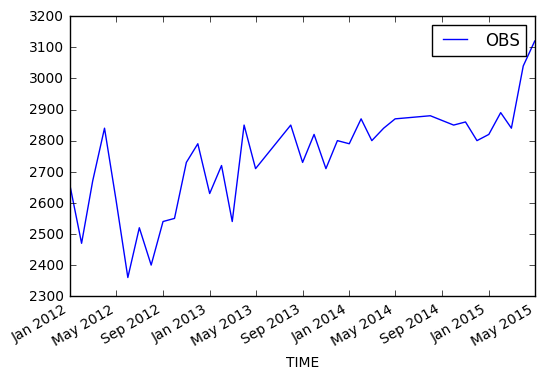

In [64]:
import pandas
from matplotlib import pyplot as plt
%matplotlib inline

# The magic of pandas control would mean we should be able to trivially throw out 
# plots of things, unstacked and separated out (I don't know how, but I'm told it's easy)

# Select one table
ot0 = outputtables[0]

# Filter down by month type
ttab = ot0[ot0.TIMEUNIT == "Month"]

# Filter by Seasonal adjustment and by All visits
ttab = ttab[(ttab["Seasonal adjustment"] == "SA") & (ttab.heading == "All Visits")]
ttab

ttab.TIME = pandas.to_datetime(ttab['TIME'])
ttab = ttab.set_index("TIME")
ttab.plot()



That's a good looking plot!  With some know-how it's possible to improve this plot labelling, or plot and combine multiple datasets, make the drawings dynamic (eg using [Altair](https://altair-viz.github.io/)), and basically perform all the operations you might have thought you needed to go to another package to complete.  

Consider using pandas.Dataframes as the native storage for processed data and being able to generate them on-the-fly from the source excel spreadsheet with no intermediate steps.  Remember: Automate, automate, and automate all the automatable processes you can. 
